In [2]:
import pandas as pd
import numpy as np
import data
import trade
import optimization as opt
import plot as pt
from matplotlib import pyplot as plt
from metrics import *

In [3]:
df = data.get_data()
df = data.excess_return_unit(df)
df = data.exponential_moving_averages(df, col='SPY')
df = data.kelly_fraction(df, col='Excess Return')
df = data.moving_averages(df, col='SPY')
df = df.fillna(df['SPY'][0])

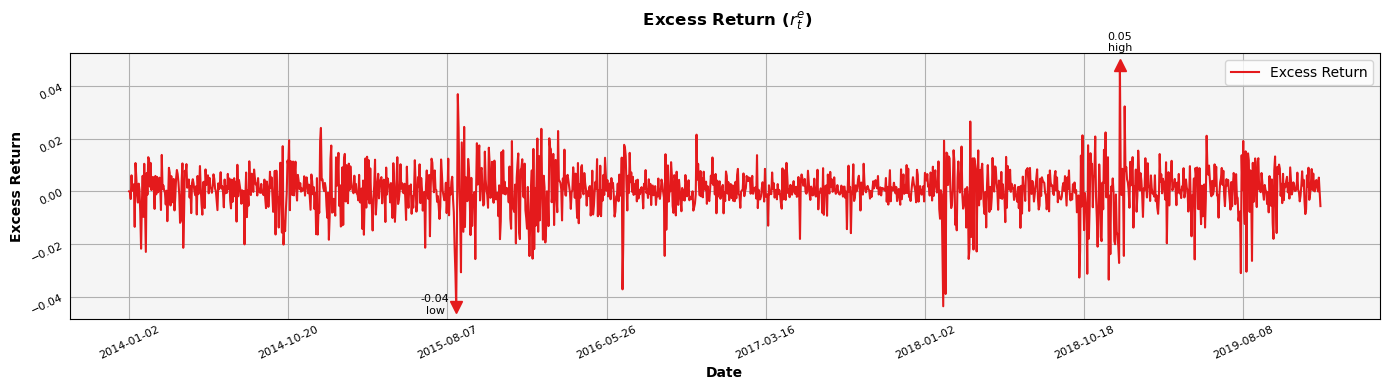

In [4]:
pt.plot_time_series_annotated(df=df, ylabel='Excess Return',x_col='Date', y_cols=['Excess Return'], title=' Excess Return ($r_t^e$)')

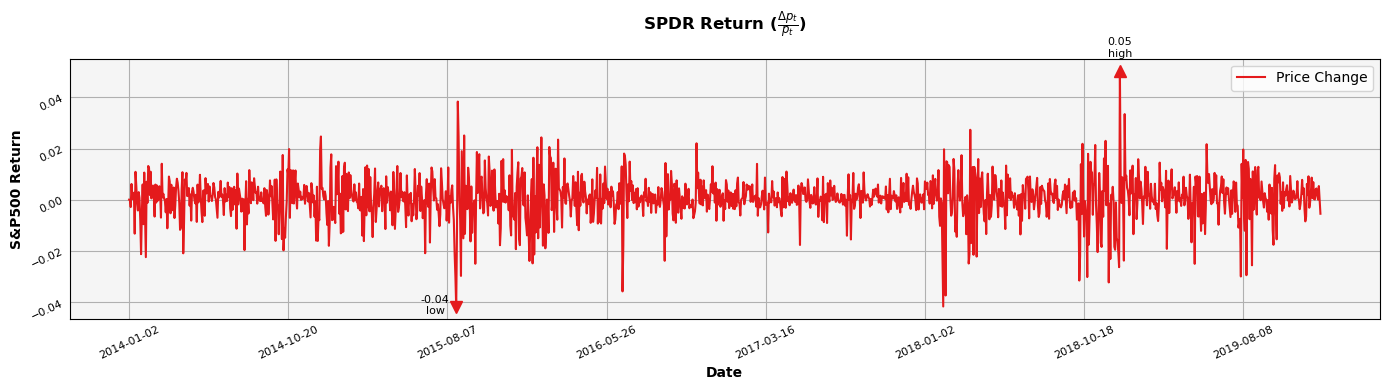

In [5]:
pt.plot_time_series_annotated(df=df, ylabel='S&P500 Return', x_col='Date', y_cols=['Price Change'], title='SPDR Return ($\\frac{\Delta p_t}{p_t}$)')

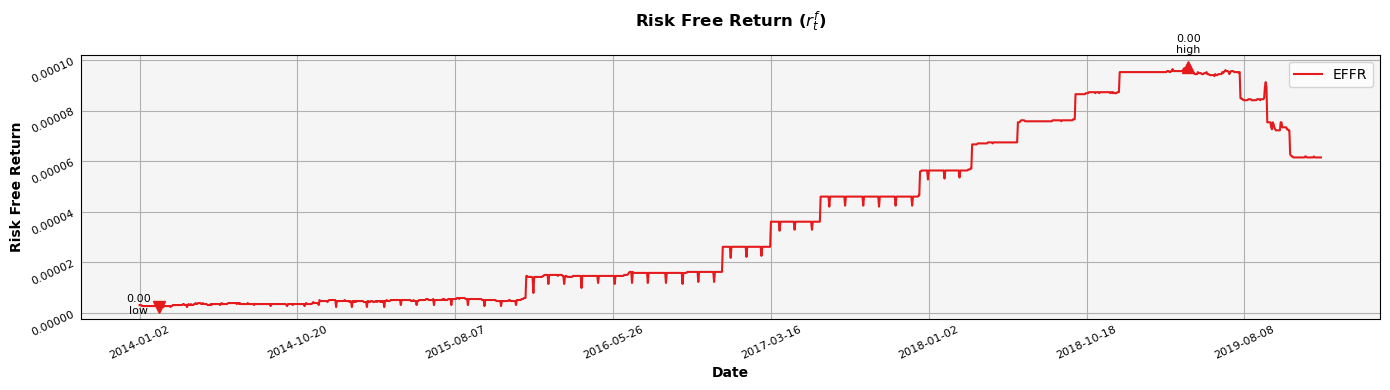

In [6]:
pt.plot_time_series_annotated(df=df, ylabel='Risk Free Return', x_col='Date', y_cols=['EFFR'], title='Risk Free Return ($r_t^f$)')

In [7]:
n_train = int( len(df) * 0.7)

df_train = df[:n_train]
df_test = df[n_train:]
# reset index to be 0 to len(df)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
df_train = trade.risk_free_buy_and_hold(df_train)
df_test = trade.risk_free_buy_and_hold(df_test)


In [9]:
df_train, best_window_bb, best_sigma_bb, best_drop_lim_bb = opt.cross_val_bollinger_band_strategy(df_train)
df_train, best_window_momentum, best_sigma_momentum = opt.cross_val_momentum_strategy(df_train)
df_train = trade.diversified_strategy(df=df_train, 
                                      window_bb=best_window_bb,
                                      sigma_bb=best_sigma_bb,
                                      drop_lim_bb=best_drop_lim_bb,
                                      window_mom=best_window_momentum,
                                      sigma_mom=best_sigma_momentum)

Best window:  20
Best sigma:  1
Best drop limit:  0.0
Best window: 10
Best sigma: 0.7894736842105263


In [10]:
df_test = trade.bollinger_band_strategy(df=df_test, 
                                        drop_lim=best_drop_lim_bb, 
                                        window=best_window_bb, 
                                        sigma=best_sigma_bb)
df_test = trade.momentum_strategy(df=df_test, 
                                  window=best_window_momentum,
                                  sigma=best_sigma_momentum)
df_test = trade.diversified_strategy(df=df_test,
                                     window_bb=best_window_bb,
                                     sigma_bb=best_sigma_bb,
                                     drop_lim_bb=best_drop_lim_bb,
                                     window_mom=best_window_momentum,
                                     sigma_mom=best_sigma_momentum)

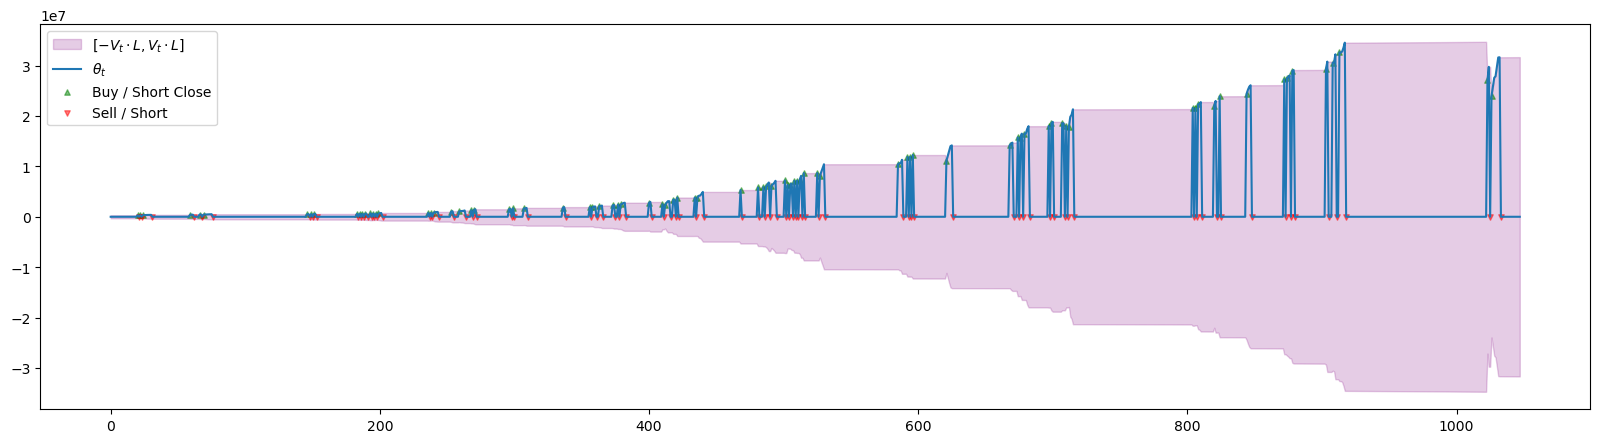

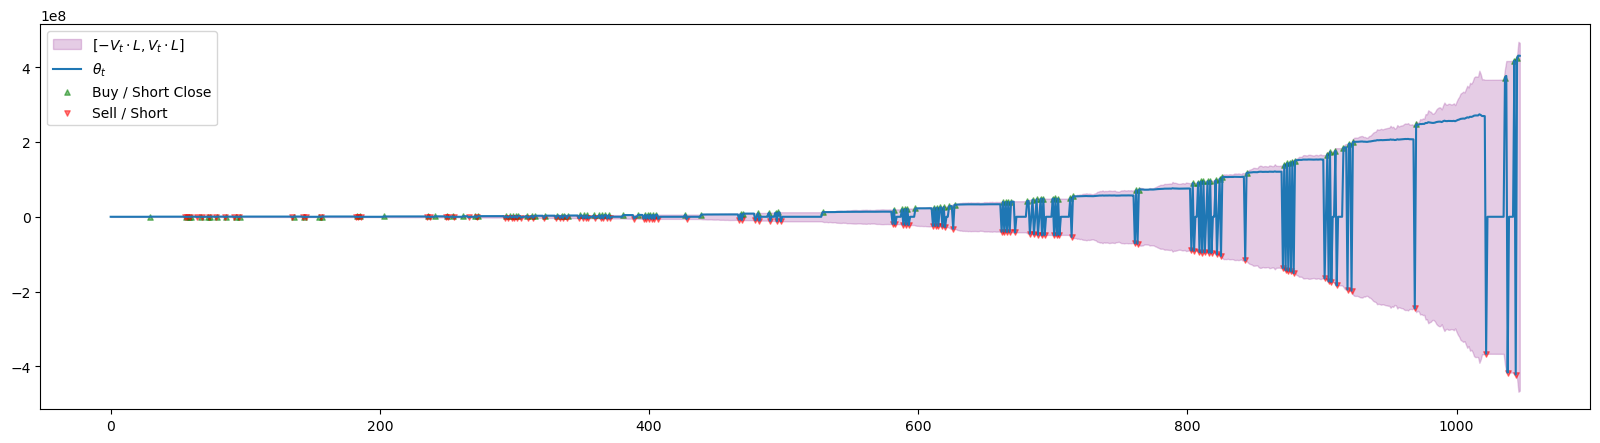

Portfolio is diversified, contradicting signals are not plotted.


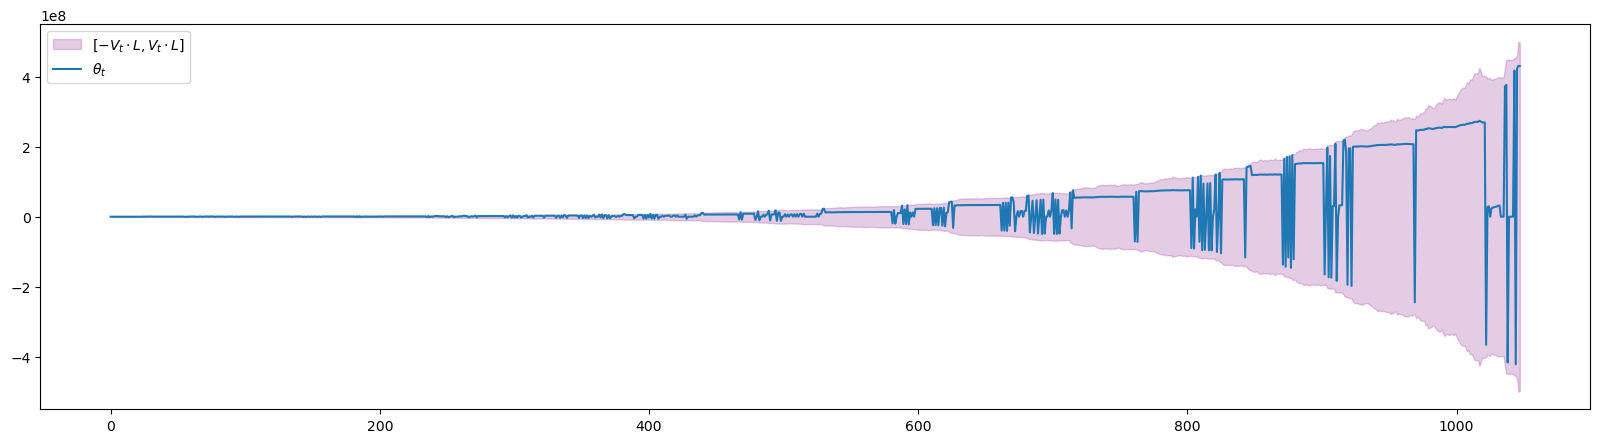

In [11]:
pt.plot_margin(df=df_train,
               strategy='BB',
               )
pt.plot_margin(df=df_train,
                strategy='Momentum',
                )
pt.plot_margin(df=df_train,
                strategy='Diversified',
                )

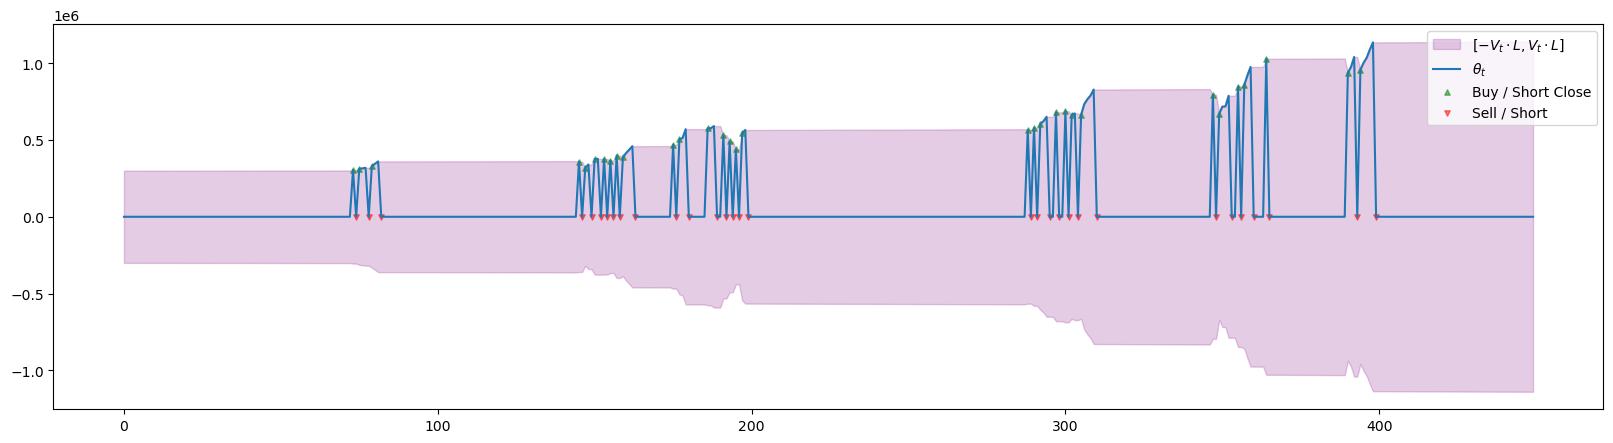

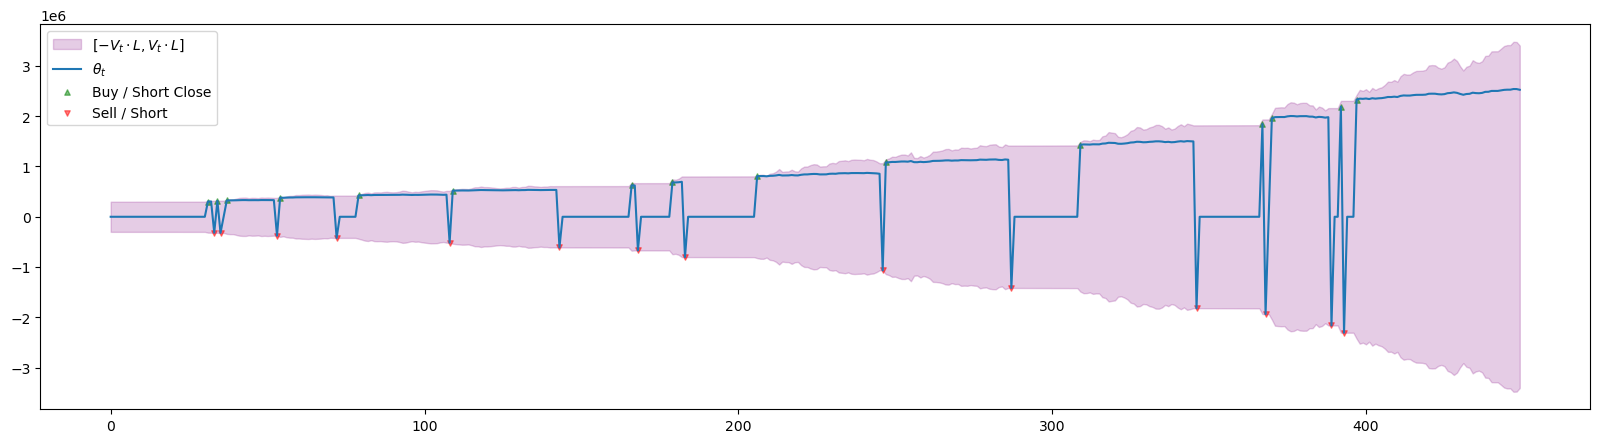

Portfolio is diversified, contradicting signals are not plotted.


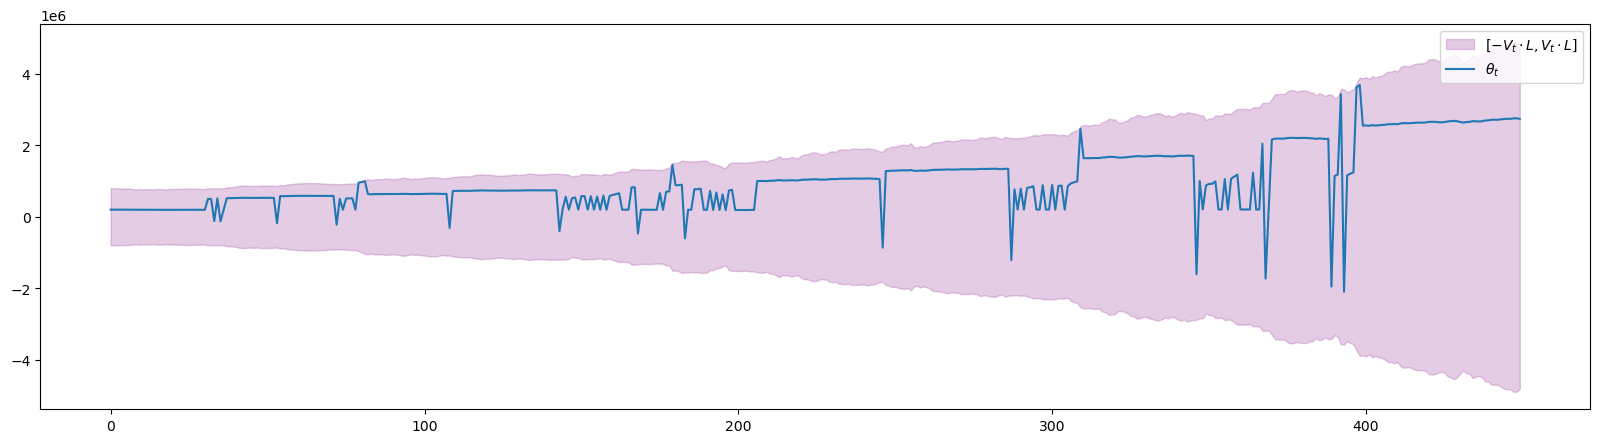

In [12]:
pt.plot_margin(df=df_test,
               strategy='BB',
               )
pt.plot_margin(df=df_test,
                strategy='Momentum',
                )
pt.plot_margin(df=df_test,
                strategy='Diversified',
                )

In [13]:
def turnover_dollars(df, strategy = 'BB'):
    """
    Calculates the turnover in dollars.
    """
    return df[f'Theta {strategy}'].diff().abs().sum()

for strategy in ['BB', 'Momentum', 'Diversified']:
    if strategy == 'BB':
        print(f'Money turnover {strategy}: \t\t ${turnover_dollars(df_test, strategy):.2f}')
    else:
        print(f'Money turnover {strategy}: \t ${turnover_dollars(df_test, strategy):.2f}')

Money turnover BB: 		 $37178770.41
Money turnover Momentum: 	 $59046667.81
Money turnover Diversified: 	 $96449275.46


In [14]:
def turnover_units(df, strategy = 'BB'):
    """
    Calculates the turnover in units.
    """
    theta = f'Theta {strategy}'
    return np.sum([ abs( df[theta][i+1] / df['SPY'][i+1] - df[theta][i] / df['SPY'][i] ) for i in range(len(df)-1)]) 

for strategy in ['BB', 'Momentum', 'Diversified']:
    if strategy == 'BB':
        print(f'Units turnover {strategy}: \t\t {turnover_units(df_test, strategy):.2f} units')
    else:
        print(f'Units turnover {strategy}: \t {turnover_units(df_test, strategy):.2f} units')


Units turnover BB: 		 141990.04 units
Units turnover Momentum: 	 215391.23 units
Units turnover Diversified: 	 357614.10 units


In [15]:
def pnl_series(df, strategy = 'BB', leverage = 5):
    """
    Creates a total PnL series for the strategies, where we assume that unused 
    capital will be put in a money-market and grow at the same risk-free rate,
    i.e., the value of your account changes by the trading PnL (∆V ) 
    and the change in the growth of the money-market capital account (∆V cap).
    """
    theta = f'Theta {strategy}'
    account = f'Account {strategy}'
    
    delta_v = df['Excess Return'] * df[theta]

    M = df[theta].abs() / leverage
    delta_vcap = (df[account] - M) * df['EFFR']

    pnl = delta_v + delta_vcap
    df[f'PnL {strategy}'] = pnl
    df[f'V {strategy}'] = delta_v
    df[f'V Cap {strategy}'] = delta_vcap

    return pnl, delta_v, delta_vcap, df


In [16]:
df_train.columns

Index(['SPY', 'Volume', 'EFFR', 'Date', 'Time', 'Price Change',
       'Excess Return', '10 EMA SPY', '20 EMA SPY', '30 EMA SPY',
       'Kelly Fraction', '10 MA SPY', '20 MA SPY', '30 MA SPY',
       'Account Risk Free', 'Account Buy and Hold', 'Theta Risk Free',
       'Theta Buy and Hold', 'BB Upper', 'BB Lower', 'Account BB', 'Signal BB',
       'Position BB', 'Theta BB', 'Signal Momentum', 'Position Momentum',
       'Account Momentum', 'Theta Momentum', 'Account Diversified',
       'Theta Diversified'],
      dtype='object')

In [17]:
_, _, _, df_train = pnl_series(df_train, strategy='Momentum')
_, _, _, df_train = pnl_series(df_train, strategy='BB')
_, _, _, df_train = pnl_series(df_train, strategy='Diversified')
_, _, _, df_train = pnl_series(df_train, strategy='Buy and Hold')

_, _, _, df_test = pnl_series(df_test, strategy='Momentum')
_, _, _, df_test = pnl_series(df_test, strategy='BB')
_, _, _, df_test = pnl_series(df_test, strategy='Diversified')
_, _, _, df_test = pnl_series(df_test, strategy='Buy and Hold')


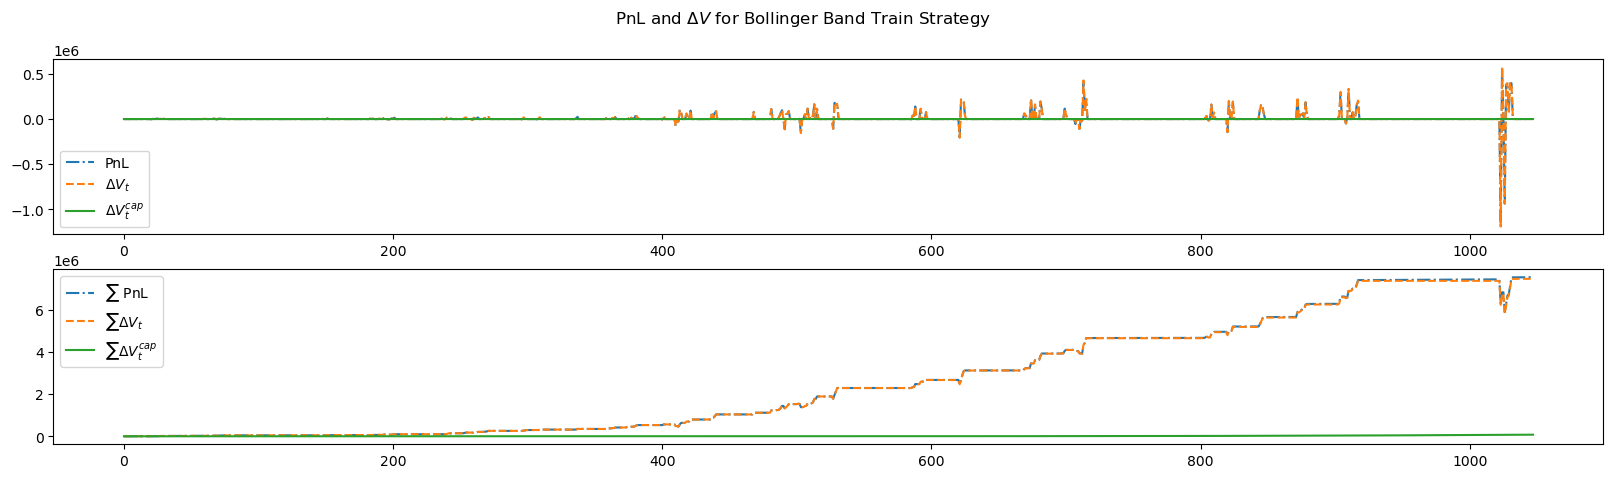

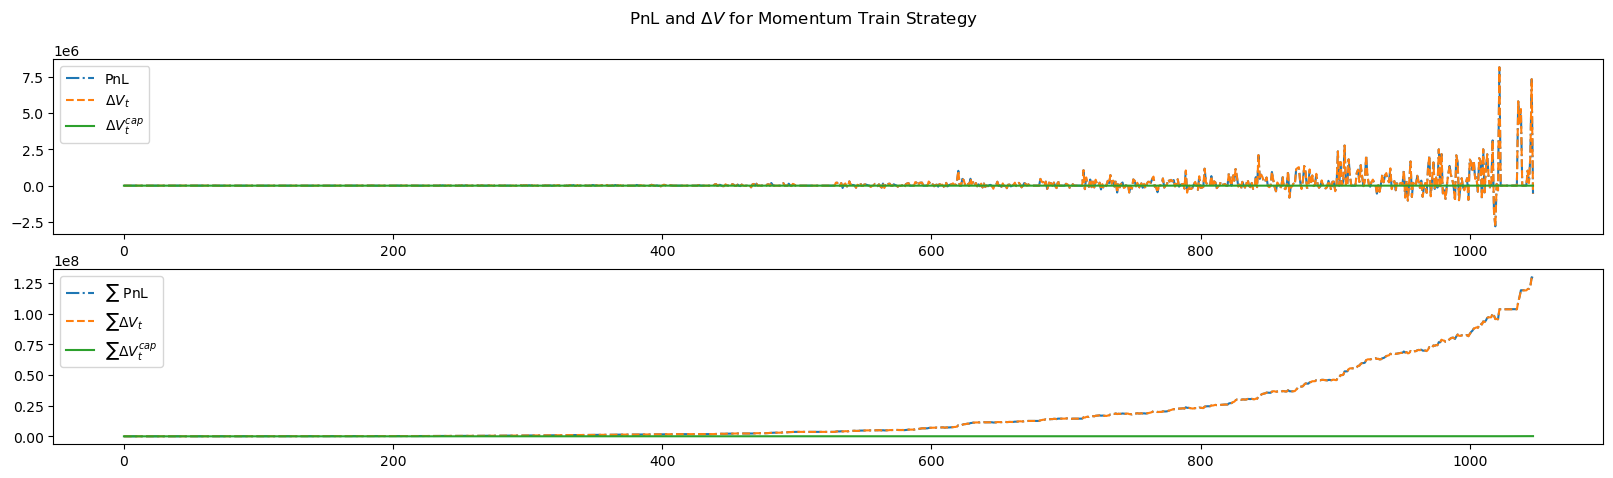

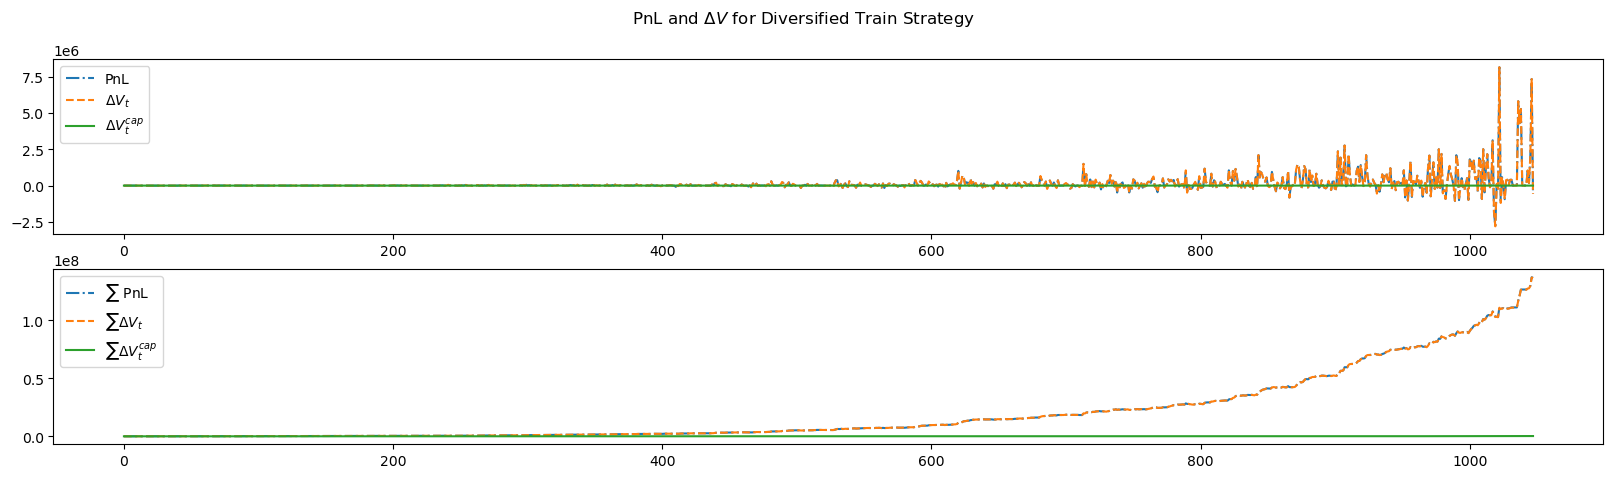

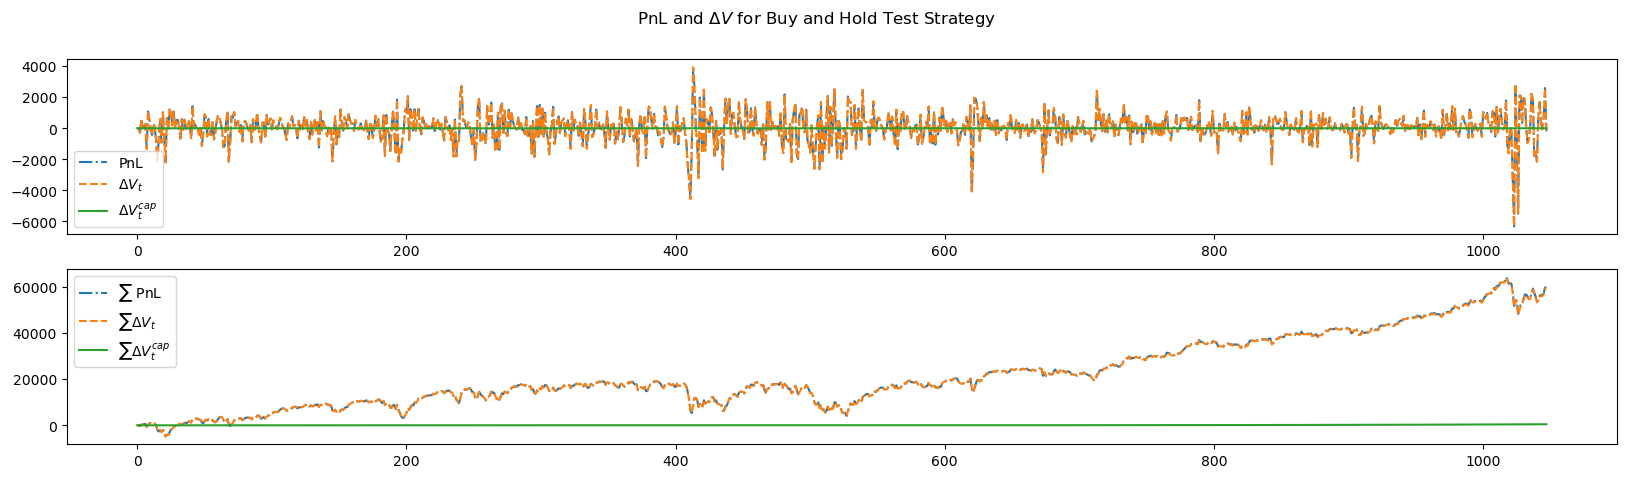

In [18]:
pt.plot_delta_V(pnl=df_train['PnL BB'], 
                delta_v=df_train['V BB'], 
                delta_vcap=df_train['V Cap BB'], 
                strategy='Bollinger Band Train')

pt.plot_delta_V(pnl=df_train['PnL Momentum'],
                delta_v=df_train['V Momentum'],
                delta_vcap=df_train['V Cap Momentum'],
                strategy='Momentum Train')

pt.plot_delta_V(pnl=df_train['PnL Diversified'],
                delta_v=df_train['V Diversified'],
                delta_vcap=df_train['V Cap Diversified'],
                strategy='Diversified Train')

pt.plot_delta_V(pnl=df_train['PnL Buy and Hold'],
                delta_v=df_train['V Buy and Hold'],
                delta_vcap=df_train['V Cap Buy and Hold'],
                strategy='Buy and Hold Test')



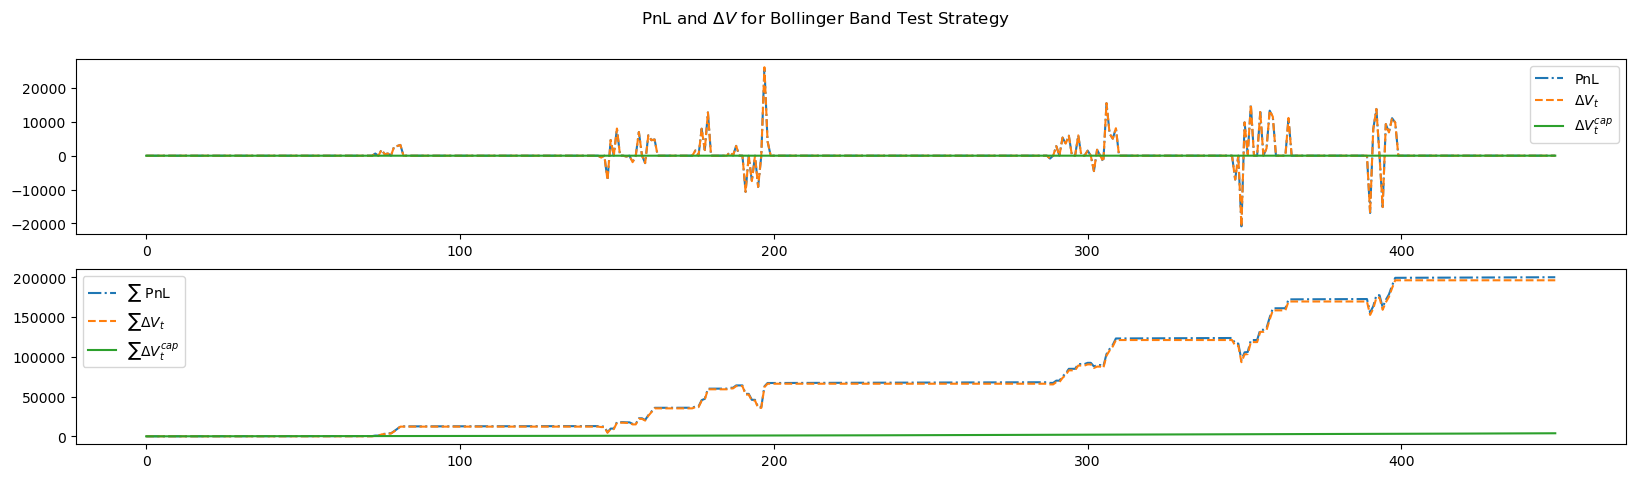

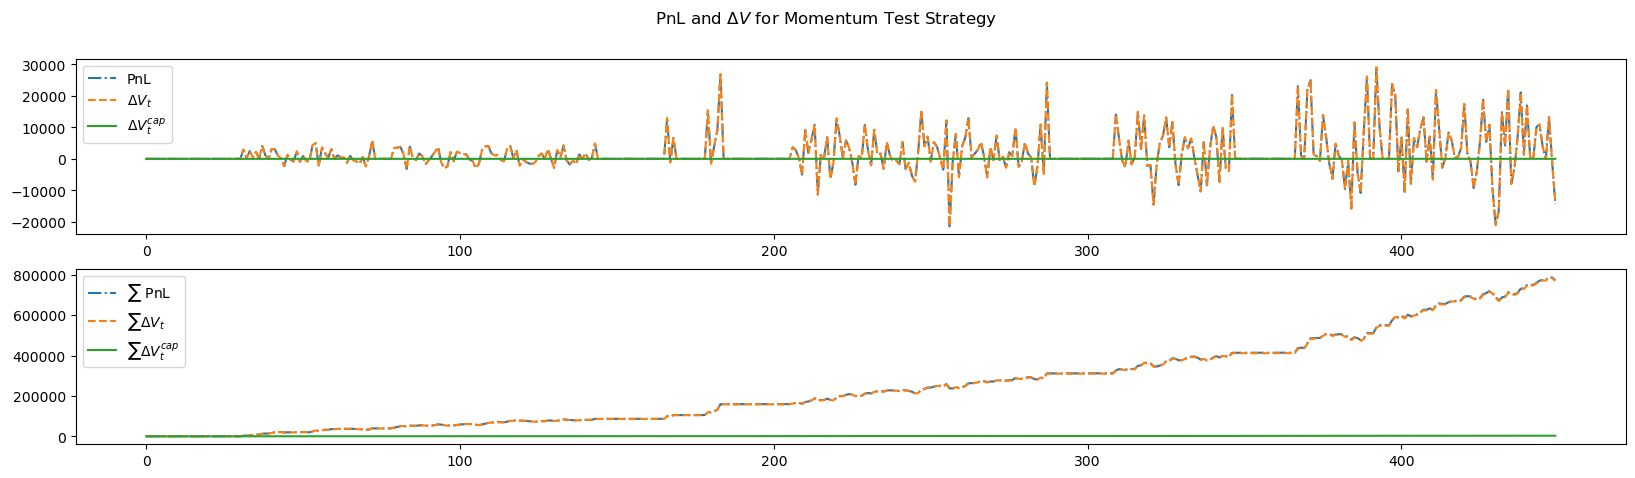

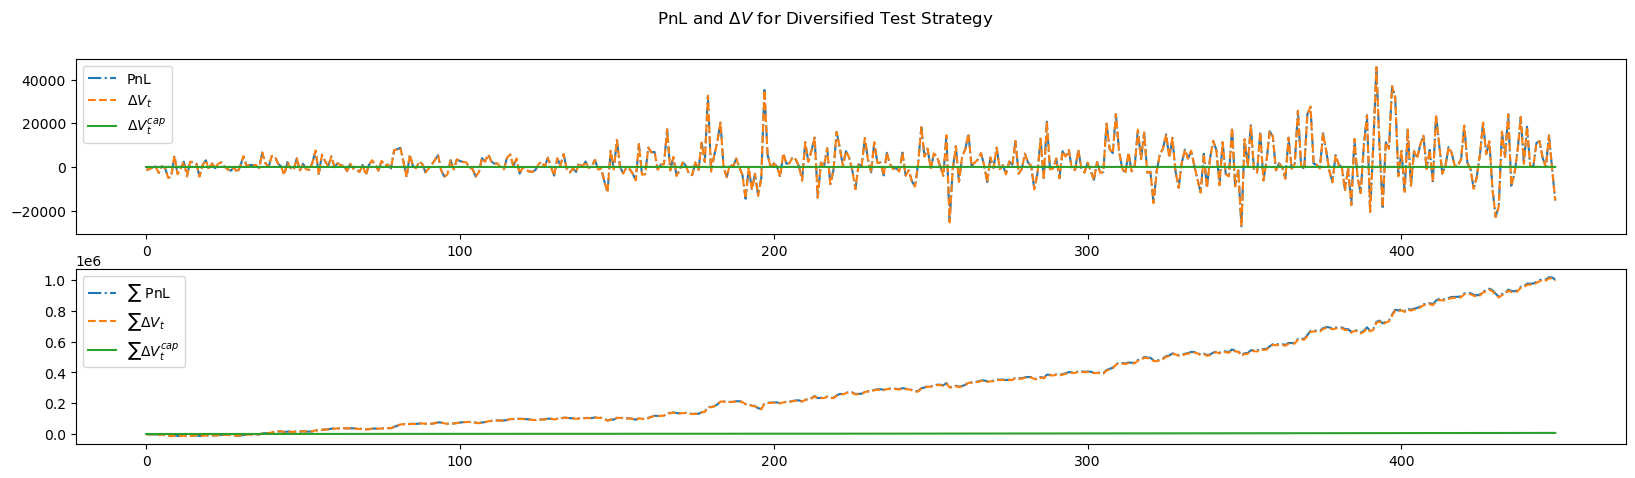

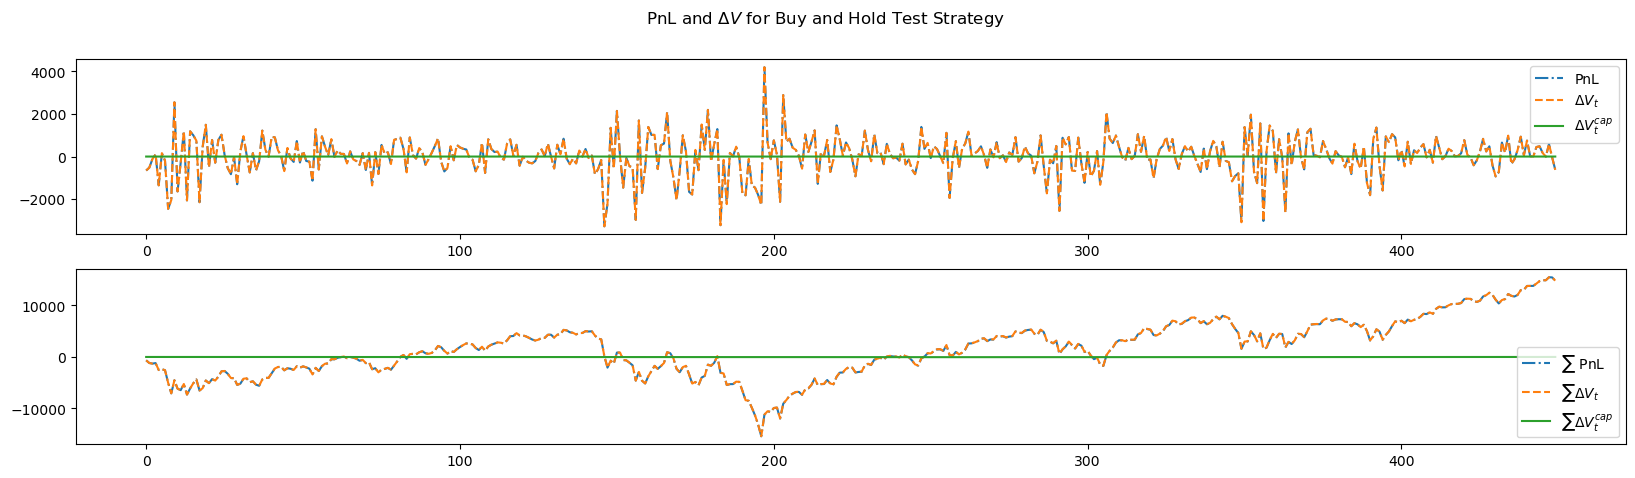

In [19]:
pt.plot_delta_V(pnl=df_test['PnL BB'],
                delta_v=df_test['V BB'],
                delta_vcap=df_test['V Cap BB'],
                strategy='Bollinger Band Test')

pt.plot_delta_V(pnl=df_test['PnL Momentum'],
                delta_v=df_test['V Momentum'],
                delta_vcap=df_test['V Cap Momentum'],
                strategy='Momentum Test')

pt.plot_delta_V(pnl=df_test['PnL Diversified'],
                delta_v=df_test['V Diversified'],
                delta_vcap=df_test['V Cap Diversified'],
                strategy='Diversified Test')

pt.plot_delta_V(pnl=df_test['PnL Buy and Hold'],
                delta_v=df_test['V Buy and Hold'],
                delta_vcap=df_test['V Cap Buy and Hold'],
                strategy='Buy and Hold Test')


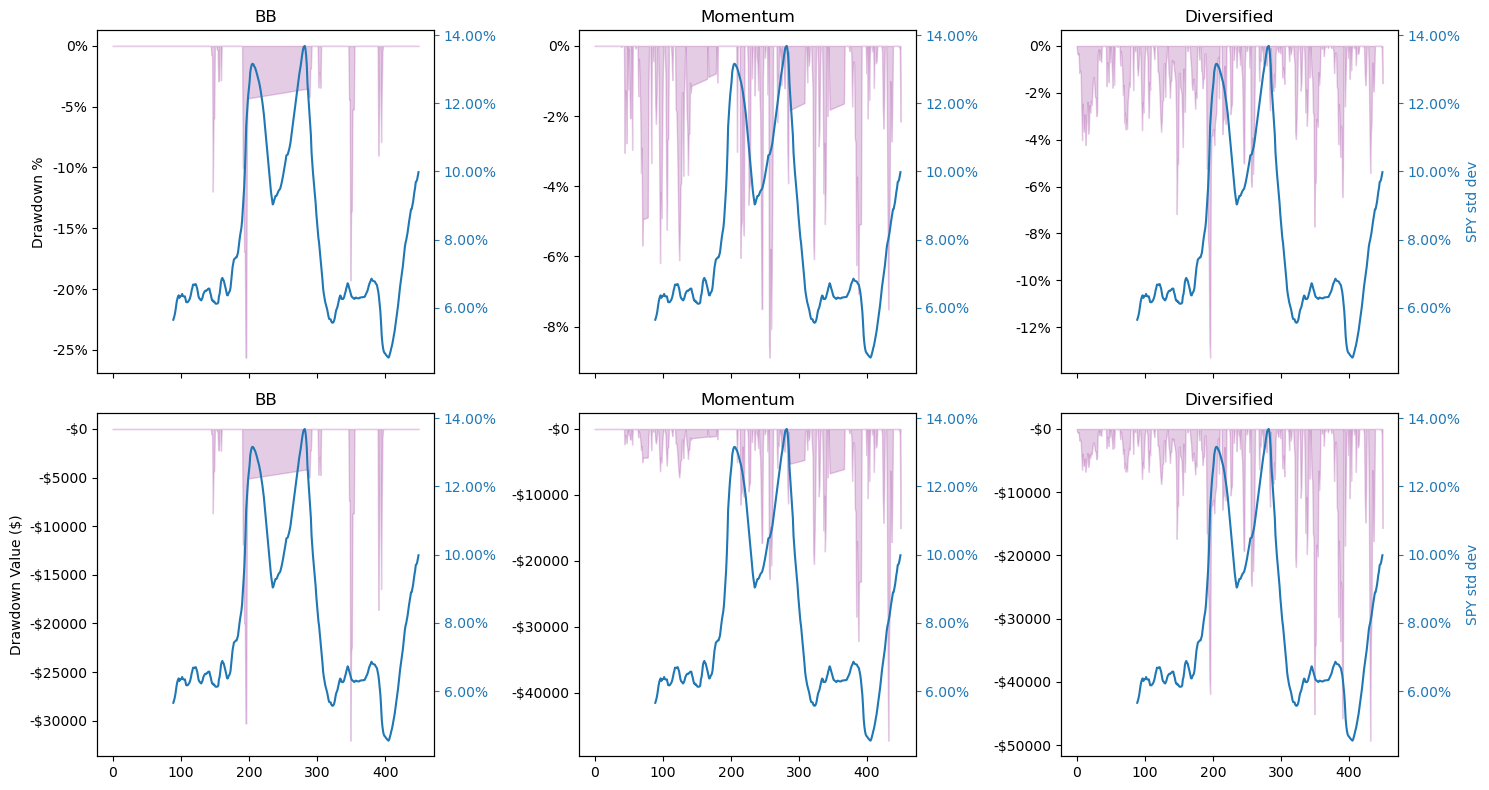

In [20]:
def drawdown_percent(df, strategy='BB'):
    """
    Calculates the drawdown of the account.
    """
    account = f'Account {strategy}'
    
    return df[account].div(df[account].cummax()).sub(1) * 100

def drawdown_value(df, strategy='BB'):
    """
    Calculates the drawdown of the account.
    """
    account = f'Account {strategy}'
    
    return df[account].sub(df[account].cummax())

fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=False)
for i, strategy in enumerate(['BB', 'Momentum', 'Diversified']):

    dd_pct = drawdown_percent(df_test, strategy=strategy)
    dd_val = drawdown_value(df_test, strategy=strategy)
    # get 90 day rolling volatility of SPY
    spy_rolling = df_test['SPY'].rolling(90).std()
    # plot drawdowns on axes where they share the column index by row
    if strategy == 'Diversified':
        ax[0, i].fill_between(x=np.arange(len(dd_pct)),
                              y1=0,
                              y2=dd_pct,
                              color='purple',
                              alpha=0.2)

        ax[1, i].fill_between(x=np.arange(len(dd_val)),
                              y1=0,
                              y2=dd_val,
                              label='Drawdown',
                              color='purple',
                              alpha=0.2)

        # set title to strategy
        ax[0, i].set_title(strategy)
        ax[1, i].set_title(strategy)

        # create secondary y-axis on each plot
        ax_sec_1 = ax[0, i].twinx()
        ax_sec_2 = ax[1, i].twinx()

        # plot SPY standard deviation on secondary y-axis
        ax_sec_1.plot(spy_rolling, color='tab:blue', label='SPY std dev')
        ax_sec_2.plot(spy_rolling, color='tab:blue', label='SPY std dev')

        # set label for secondary y-axis on each plot
        ax_sec_1.set_ylabel('SPY std dev', color='tab:blue')
        ax_sec_2.set_ylabel('SPY std dev', color='tab:blue')

        # set ticks for secondary y-axis to be in percent
        ax_sec_1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
        ax_sec_2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))

        # set colors for labels on secondary y-axis to match lines
        ax_sec_1.tick_params(axis='y', colors='tab:blue')
        ax_sec_2.tick_params(axis='y', colors='tab:blue')

    else:
        ax[0, i].fill_between(x=np.arange(len(dd_pct)),
                              y1=0,
                              y2=dd_pct,
                              color = 'purple',
                              alpha=0.2)

        ax[1, i].fill_between(x=np.arange(len(dd_val)),
                              y1=0,
                              y2=dd_val,
                              color='purple',
                              alpha=0.2)
    

        # set title to strategy
        ax[0, i].set_title(strategy)
        ax[1, i].set_title(strategy)

        # create secondary y-axis on each plot
        ax_sec_1 = ax[0, i].twinx()
        ax_sec_2 = ax[1, i].twinx()

        # plot SPY standard deviation on secondary y-axis
        ax_sec_1.plot(spy_rolling, color='tab:blue')
        ax_sec_2.plot(spy_rolling, color='tab:blue')

        # set label for secondary y-axis on each plot
        # ax_sec_1.set_ylabel('SPY std dev', color='tab:blue')
        # ax_sec_2.set_ylabel('SPY std dev', color='tab:blue')

        # set ticks for secondary y-axis to be in percent
        ax_sec_1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
        ax_sec_2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))

        # set colors for labels on secondary y-axis to match lines
        ax_sec_1.tick_params(axis='y', colors='tab:blue')
        ax_sec_2.tick_params(axis='y', colors='tab:blue')

ax[0, 0].set_ylabel('Drawdown %')
ax[1, 0].set_ylabel('Drawdown Value ($)')

# set ticks for row 1 and 2 to be in percent and dollar for all entries
for i in range(3):
        ax[0, i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
        ax[1, i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'-${abs(x):.0f}'))

plt.tight_layout()



In [24]:
# for all strategies compute percentage change as (V_t - V_t-1) / V_t-1 where V is the account value
# call the column Pct Change (strategy)
for strategy in ['BB', 'Momentum', 'Diversified', 'Buy and Hold']:
    if strategy == 'SPY':
        df_train[f'Pct Change {strategy}'] = df_train[f'{strategy}'].pct_change()
        df_test[f'Pct Change {strategy}'] = df_test[f'{strategy}'].pct_change()
    else:
        df_train[f'Pct Change {strategy}'] = df_train[f'Account {strategy}'].pct_change()
        df_test[f'Pct Change {strategy}'] = df_test[f'Account {strategy}'].pct_change()



In [25]:
def compunded_rate(df, strategy='BB'):
    """
    Calculates the Calmar ratio of the account.
    """

    compounded_return = (1 + df[f'Pct Change {strategy}']).cumprod()
    cr = compounded_return.iloc[-1]
    
    return cr 

def calmar_ratio(df, strategy='BB'):
    """
    Calculates the Calmar ratio of the account.
    """

    compounded_return = (1 + df[f'Pct Change {strategy}']).cumprod()
    cr = compounded_return.iloc[-1]
    dd = drawdown_value(df, strategy=strategy)
    
    max_dd = dd.min()
    print(max_dd)
    calmar = cr / abs(max_dd)
    
    return calmar

In [27]:
import numpy as np
def tracking_error(asset_return, portfolio_return):
    """
    Calculates the tracking error of the portfolio.
    """
    return_diff = portfolio_return - asset_return
    return np.sqrt(np.sum((return_diff) ** 2) / (len(asset_return) - 1))

# calculate tracking error for the strategies on the training set
for strategy in ['BB', 'Momentum', 'Diversified']:
    te = tracking_error(asset_return=df_train['Excess Return'],
                        portfolio_return=df_train[f'Pct Change {strategy}'],
                       )
    print(f'Tracking error for {strategy} is {te:.3f}')


Tracking error for BB is 0.020
Tracking error for Momentum is 0.018
Tracking error for Diversified is 0.014


In [28]:

for strategy in ['BB', 'Momentum', 'Diversified']:
    print(f'Compounded return for {strategy}: {compunded_rate(df_test, strategy=strategy)}')
    print(f'Compounded return for {strategy}: {compunded_rate(df_train, strategy=strategy)}')

    print('\n')
    # print calmar ratio
    print(f'Calmar ratio for {strategy}: {calmar_ratio(df_test, strategy=strategy)}')
    print(f'Calmar ratio for {strategy}: {calmar_ratio(df_train, strategy=strategy)}')

    print('\n')
  

Compounded return for BB: 3.7972738903657177
Compounded return for BB: 105.62971348535866


-32057.725832366763
Calmar ratio for BB: 0.00011845113125684786
-2156326.6260497933
Calmar ratio for BB: 4.898595241058786e-05


Compounded return for Momentum: 11.344003662529628
Compounded return for Momentum: 1551.5437222930855


-47249.140685700346
Calmar ratio for Momentum: 0.00024008909998997759
-4885274.505937755
Calmar ratio for Momentum: 0.0003175960164382325


Compounded return for Diversified: 6.025207065273841
Compounded return for Diversified: 622.0248260236918


-49280.77890476491
Calmar ratio for Diversified: 0.00012226282131046573
-7035558.112471104
Calmar ratio for Diversified: 8.841158243311243e-05




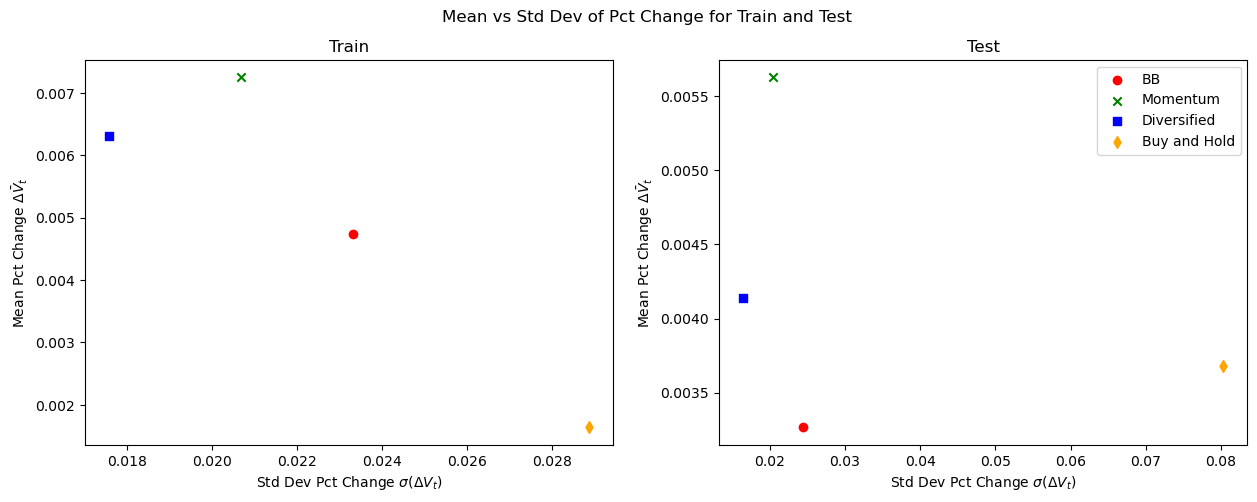

In [29]:
# annotate the mean vs std dev plot for train and test for different strategies
def annotate_plot(df_train, df_test):
    colors = ['red', 'green', 'blue', 'orange']
    markers = ['o', 'x', 's', 'd']
    strategies = ['BB', 'Momentum', 'Diversified', 'Buy and Hold']
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for strategy, color, marker in zip(strategies, colors, markers):
        # scatter mean percentage change vs std dev for train and test
        ax[0].scatter(df_train[f'Pct Change {strategy}'].std(), df_train[f'Pct Change {strategy}'].mean(), color=color, marker=marker, label=f'{strategy}')
        ax[1].scatter(df_test[f'Pct Change {strategy}'].std(), df_test[f'Pct Change {strategy}'].mean(), color=color, marker=marker, label=f'{strategy}')
    
    # set labels and legend
    ax[0].set_ylabel('Mean Pct Change $\\bar{\Delta V_t}$')
    ax[0].set_xlabel('Std Dev Pct Change $\sigma(\Delta V_t)$')

    ax[1].set_ylabel('Mean Pct Change $\\bar{\Delta V_t}$')
    ax[1].set_xlabel('Std Dev Pct Change $\sigma(\Delta V_t)$')

    ax[0].set_title('Train')
    ax[1].set_title('Test')
    
    plt.suptitle('Mean vs Std Dev of Pct Change for Train and Test')
    ax[1].legend()
    plt.show()

annotate_plot(df_train, df_test)